Loading data...
Engineering features...
Preparing training data...
Training models...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

Model Performance:
RMSE: 0.0556
SVD RMSE: 0.0556
RMSE: 0.0593
KNN RMSE: 0.0593

Analyzing recommendations for user 7...

Top Recommendations with Scores:
Event ID: 10, Event Name: Music Festival, Hybrid Score: 0.8856
Event ID: 9, Event Name: Holiday Gala, Hybrid Score: 0.7829
Event ID: 7, Event Name: Nightlife Party, Hybrid Score: 0.7539
Event ID: 32, Event Name: Pigs in blankets eating competition, Hybrid Score: 0.7485
Event ID: 30, Event Name: BLACK SHEEP Live in Manchester, Hybrid Score: 0.4434
Event ID: 23, Event Name: PATS Training at Bulkington Community & Conference Centre, Hybrid Score: 0.4371
Event ID: 31, Event Name: SHABAZ & SMASH COMEDY NIGHT, Hybrid Score: 0.4177
Event ID: 22, Event Name: Introduction to Artificial Intelligence (AI), Hybrid Score: 0.4144
Event ID: 26, Even

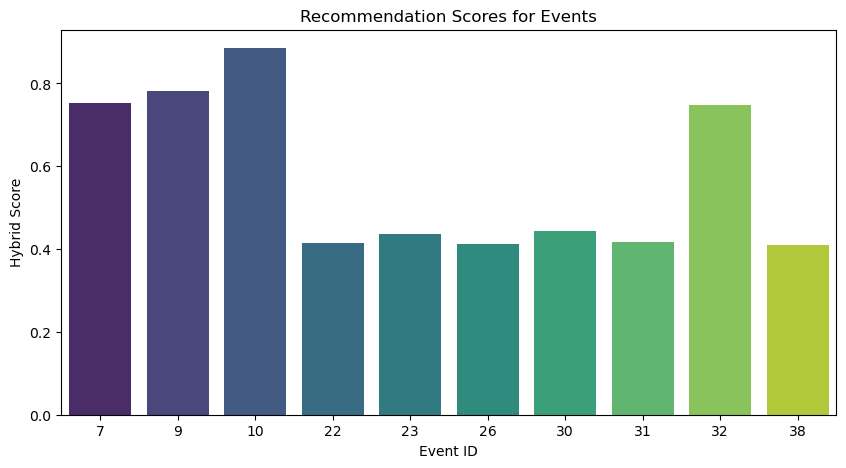

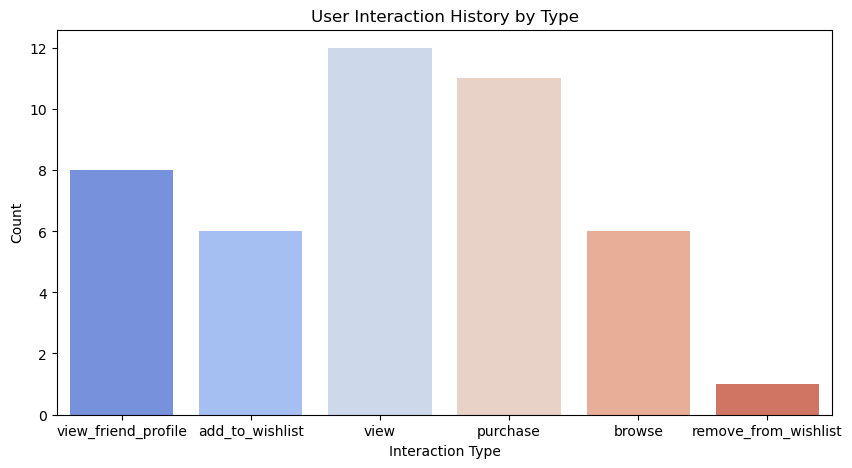


Recommendation Diversity: 0.90


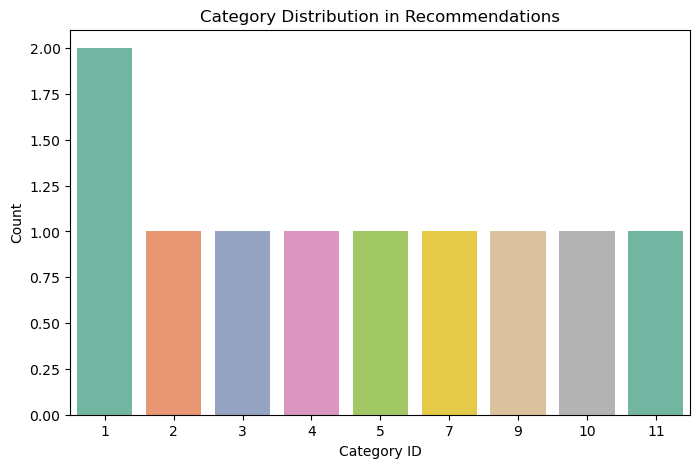


Evaluation Metrics:
RMSE: 0.0556
SVD RMSE: 0.0556
RMSE: 0.0593
KNN RMSE: 0.0593

User Similarity Analysis: Social Preference Overlap: 0.30


In [117]:
import pandas as pd
import numpy as np
from scipy.io import arff
from surprise import Dataset, Reader, SVD, KNNWithMeans, accuracy
from surprise.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Loading Function
def load_and_preprocess_data():
    """Load and preprocess all datasets"""
    user_behavior = pd.DataFrame(arff.loadarff('cleaned_user_behaviour_new.arff')[0])
    events = pd.read_csv('events.csv')
    users = pd.read_csv('users.csv')
    tickets = pd.read_csv('tickets.csv')
    preferred_categories = pd.read_csv('user_preferred_categories.csv')
    friends = pd.read_csv('friends.csv')
    
    for col in user_behavior.select_dtypes([object]):
        user_behavior[col] = user_behavior[col].str.decode('utf-8')
    
    user_behavior['user_id'] = user_behavior['user_id'].astype(int)
    user_behavior['event_id'] = user_behavior['event_id'].astype(int)
    
    return user_behavior, events, users, tickets, preferred_categories, friends

# 2. Feature Engineering Function
def create_user_features(user_behavior, events, users, tickets, preferred_categories, friends):
    df = user_behavior.copy()
    interaction_weights = {
        'browse': 3.0,
        'view': 3.5,
        'purchase': 6.0,
        'add_to_wishlist': 4.0,
        'remove_from_wishlist': 0,
        'view_friend_profile': 3.5
    }
    df['interaction_value'] = df['interaction_type'].map(interaction_weights)
    df['session_score'] = StandardScaler().fit_transform(df[['session_length']])
    df['category_preference'] = df.apply(
        lambda x: 3 if x['event_category_id'] == x['preferred_category1'] else
                 2 if x['event_category_id'] == x['preferred_category2'] else
                 1 if x['event_category_id'] == x['preferred_category3'] else 0,
        axis=1
    )
    df['location_match'] = (df['event_location'] == df['user_location']).astype(int)
    df['user_activity_count'] = df.groupby('user_id')['interaction_value'].transform('count')
    df['user_category_count'] = df.groupby(['user_id', 'event_category_id'])['interaction_value'].transform('count')
    if 'friend_id' in df.columns:
        df['friend_interaction_count'] = df.groupby(['user_id', 'friend_id'])['interaction_value'].transform('count')
    
    return df

# 3. Create Training Data
def prepare_training_data(df):
    df['final_score'] = (
        df['interaction_value'] * 0.3 +
        df['category_preference'] * 0.3 +
        df['session_score'] * 0.2 +
        df['location_match'] * 0.1 +
        df['user_activity_count'] * 0.1
    )
    df['final_score'] = MinMaxScaler().fit_transform(df[['final_score']])

    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df(
        df[['user_id', 'event_id', 'final_score']],
        reader
    )
    return train_test_split(data, test_size=0.2, random_state=42)

# 4. Train Models
def train_recommendation_models(trainset):
    svd = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)
    knn = KNNWithMeans(k=20, min_k=2, sim_options={'name': 'pearson_baseline', 'user_based': True, 'min_support': 2})
    svd.fit(trainset)
    knn.fit(trainset)
    return svd, knn

# 5. Get Recommendations with Preferred Category Boost
def get_recommendations(user_id, svd_model, knn_model, events_df, user_behavior_df, preferred_categories_df, n_recommendations=5):
    purchased_events = user_behavior_df[(user_behavior_df['user_id'] == user_id) & 
                                        (user_behavior_df['interaction_type'] == 'purchase')]['event_id'].unique()
    user_prefs = preferred_categories_df[preferred_categories_df['user_id'] == user_id]
    user_top_categories = set(user_prefs['category_id'].unique())
    
    preferred_category_boost = 0.4
    predictions = []
    
    for event_id in events_df['event_id'].unique():
        if event_id in purchased_events:
            continue
        try:
            svd_pred = svd_model.predict(user_id, event_id).est
            knn_pred = knn_model.predict(user_id, event_id).est
            hybrid_score = 0.6 * svd_pred + 0.4 * knn_pred
            event_category_id = events_df[events_df['event_id'] == event_id]['category_id'].values[0]
            if event_category_id in user_top_categories:
                hybrid_score += preferred_category_boost

            # Clip the hybrid score to not exceed 1
            hybrid_score = np.clip(hybrid_score, 0, 1.0)
            
            predictions.append({
                'event_id': event_id,
                'hybrid_score': hybrid_score
            })
        except Exception as e:
            continue
    
    return pd.DataFrame(predictions).nlargest(n_recommendations, 'hybrid_score')

# Main execution
print("Loading data...")
user_behavior, events, users, tickets, preferred_categories, friends = load_and_preprocess_data()

print("Engineering features...")
df_engineered = create_user_features(user_behavior, events, users, tickets, preferred_categories, friends)

print("Preparing training data...")
trainset, testset = prepare_training_data(df_engineered)

print("Training models...")
svd_model, knn_model = train_recommendation_models(trainset)

# Evaluate models
svd_predictions = svd_model.test(testset)
knn_predictions = knn_model.test(testset)

print("\nModel Performance:")
print(f"SVD RMSE: {accuracy.rmse(svd_predictions):.4f}")
print(f"KNN RMSE: {accuracy.rmse(knn_predictions):.4f}")

def analyze_recommendations(user_id, n_recommendations=10):
    print(f"\nAnalyzing recommendations for user {user_id}...")
    recommendations = get_recommendations(user_id, svd_model, knn_model, events, user_behavior, preferred_categories, n_recommendations)
    recommendations = recommendations.merge(events, on='event_id', how='left')
    
    # Print recommendations with scores
    print("\nTop Recommendations with Scores:")
    for _, row in recommendations.iterrows():
        print(f"Event ID: {row['event_id']}, Event Name: {row['event_name']}, Hybrid Score: {row['hybrid_score']:.4f}")
    
    # Visualize recommendation scores
    plt.figure(figsize=(10, 5))
    sns.barplot(data=recommendations, x='event_id', y='hybrid_score', palette="viridis")
    plt.title("Recommendation Scores for Events")
    plt.xlabel("Event ID")
    plt.ylabel("Hybrid Score")
    plt.show()
    
    # Print user interaction history
    user_history = df_engineered[df_engineered['user_id'] == user_id].copy()
    
    # Visualize interaction history
    plt.figure(figsize=(10, 5))
    sns.countplot(data=user_history, x='interaction_type', palette="coolwarm")
    plt.title("User Interaction History by Type")
    plt.xlabel("Interaction Type")
    plt.ylabel("Count")
    plt.show()
    
    # Calculate and print recommendation diversity
    category_diversity = len(recommendations['category_id'].unique()) / len(recommendations)
    print(f"\nRecommendation Diversity: {category_diversity:.2f}")
    
    # Show category distribution in recommendations
    plt.figure(figsize=(8, 5))
    sns.countplot(data=recommendations, x='category_id', palette="Set2")
    plt.title("Category Distribution in Recommendations")
    plt.xlabel("Category ID")
    plt.ylabel("Count")
    plt.show()
    
    # Print evaluation metrics
    print("\nEvaluation Metrics:")
    print(f"SVD RMSE: {accuracy.rmse(svd_predictions):.4f}")
    print(f"KNN RMSE: {accuracy.rmse(knn_predictions):.4f}")
    
    # Print user similarity analysis (Social preference overlap)
    user_friends = friends[friends['user_id'] == user_id]
    friend_categories = set()
    for friend_id in user_friends['friend_id']:
        friend_prefs = preferred_categories[preferred_categories['user_id'] == friend_id]
        if not friend_prefs.empty:
            friend_categories.update(friend_prefs['category_id'].unique())
    social_overlap = len(set(recommendations['category_id']).intersection(friend_categories)) / len(recommendations)
    print(f"\nUser Similarity Analysis: Social Preference Overlap: {social_overlap:.2f}")

    return recommendations



# Get complete analysis for user
test_user_id = 7
detailed_recommendations = analyze_recommendations(test_user_id)

# Save recommendations to csv (optional)
detailed_recommendations.to_csv(f'recommendations_user_{test_user_id}.csv', index=False)


In [119]:
# Function to recommend top events for a specific user using SVD
def recommend_events_svd(user_id, svd_model, events_df, n_recommendations=10):
    """Get top N recommendations for a user using the SVD model."""
    svd_recommendations = []
    for event_id in events_df['event_id']:
        # Predict score for each event
        svd_pred = svd_model.predict(user_id, event_id).est
        svd_recommendations.append({'event_id': event_id, 'svd_score': svd_pred})
    
    # Convert to DataFrame and get top recommendations
    svd_recommendations_df = pd.DataFrame(svd_recommendations)
    return svd_recommendations_df.nlargest(n_recommendations, 'svd_score')

# Function to recommend top events for a specific user using KNN
def recommend_events_knn(user_id, knn_model, events_df, n_recommendations=5):
    """Get top N recommendations for a user using the KNN model."""
    knn_recommendations = []
    for event_id in events_df['event_id']:
        # Predict score for each event
        knn_pred = knn_model.predict(user_id, event_id).est
        knn_recommendations.append({'event_id': event_id, 'knn_score': knn_pred})
    
    # Convert to DataFrame and get top recommendations
    knn_recommendations_df = pd.DataFrame(knn_recommendations)
    return knn_recommendations_df.nlargest(n_recommendations, 'knn_score')

# Generate recommendations for user ID 8 using both models
user_id = 7
print(f"Top SVD Recommendations for User {user_id}:")
svd_top_recommendations = recommend_events_svd(user_id, svd_model, events, n_recommendations=10)
print(svd_top_recommendations)

print(f"\nTop KNN Recommendations for User {user_id}:")
knn_top_recommendations = recommend_events_knn(user_id, knn_model, events, n_recommendations=10)
print(knn_top_recommendations)


Top SVD Recommendations for User 7:
    event_id  svd_score
3         10   0.517994
16        23   0.488813
23        30   0.455717
24        31   0.447765
15        22   0.442185
8         15   0.441529
19        26   0.438595
1          8   0.430715
31        38   0.422211
37        44   0.420415

Top KNN Recommendations for User 7:
    event_id  knn_score
1          8   0.446895
3         10   0.436938
22        29   0.429704
32        39   0.429704
33        40   0.429704
34        41   0.429704
36        43   0.429704
39        46   0.429704
41        48   0.429704
23        30   0.424978


In [121]:
import pickle
# Train and save the hybrid model
def train_and_save_hybrid_model(trainset, svd_filename='svd_recommendation_model.pkl', knn_filename='knn_recommendation_model.pkl', hybrid_filename='hybrid_recommendation_model.pkl'):
    # Train SVD and KNN models
    svd_model = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)
    knn_model = KNNWithMeans(k=20, min_k=2, sim_options={'name': 'pearson_baseline', 'user_based': True, 'min_support': 2})
    svd_model.fit(trainset)
    knn_model.fit(trainset)
    
    # Save individual models if needed for standalone testing
    with open(svd_filename, 'wb') as file:
        pickle.dump(svd_model, file)
    with open(knn_filename, 'wb') as file:
        pickle.dump(knn_model, file)
    
    # Create a hybrid dictionary
    hybrid_model = {
        'svd_model': svd_model,
        'knn_model': knn_model
    }
    
    # Save the hybrid model
    with open(hybrid_filename, 'wb') as file:
        pickle.dump(hybrid_model, file)
    
    print(f"Hybrid model saved to {hybrid_filename}")
    return hybrid_model

# Training and saving the hybrid model
print("Training and saving the hybrid recommendation model...")
hybrid_model = train_and_save_hybrid_model(trainset)


Training and saving the hybrid recommendation model...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Hybrid model saved to hybrid_recommendation_model.pkl
